# 核密度估计KDE

- 高斯混合模型（GMM）——一个聚类和密度评估器的混合体。 
    - 密度评估器是一种利用 D 维数据集生成 D 维概率分布估计的算法
    - GMM 算法用不同高斯分布的加权汇总来表示概率分布估计
- 核密度估计（kernel density estimation， KDE） 算法将高斯混合理念扩展到了逻辑极限（logical extreme） 。 
    - 它通过对每个点生成高斯分布的混合成分， 获得本质上是无参数的密度评估器

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import numpy as np

## 1. KDE的由来：直方图

- 密度评估器是一种寻找数据集生成概率分布模型的算法
- 一维数据的密度估计——直方图
    - 直方图将数据分成若干区间， 统计落入每个区间内的点的数量， 然后用直观的方式将结果可视化
    - 标准直方图可以用 plt.hist() 函数来生成, 只要确定直方图的 normed 参数， 就可以得到一个正态分布直方图
    - 在这个直方图中， 区间的高度并不反映统计频次， 而是反映概率密度

In [2]:
def make_data(N, f=0.3, rseed=1):
    rand = np.random.RandomState(rseed)
    x = rand.randn(N)
    x[int(f * N):] += 5
    return x
x = make_data(1000)
# print(x)

C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


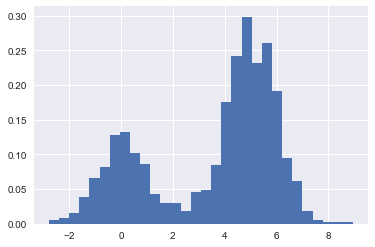

In [3]:
hist = plt.hist(x, bins=30, normed=True)

- 这个标准化（计算概率密度） 只是简单地改变了 y 轴的比例， 相对高度仍然与频次直方图一致
    - 标准化是为了让直方图的总面积等于 1

In [4]:
density, bins, patchs = hist
width = bins[1:] - bins[:-1]
print(density)
print(patchs)
print((density * width).sum())

[0.00510565 0.00765847 0.01531695 0.03829237 0.06637345 0.08169039
 0.12764124 0.13274689 0.10211299 0.08679604 0.04339802 0.0306339
 0.0306339  0.01786977 0.04595085 0.04850367 0.08424322 0.17614491
 0.24251836 0.2986805  0.23230706 0.26038813 0.19146186 0.09445452
 0.0612678  0.01786977 0.00510565 0.00255282 0.00255282 0.00255282]
<a list of 30 Patch objects>
1.0


- 使用直方图作为密度评估器时需要注意的是， 区间大小和位置的选择不同， 产生的统计特征也不同
    - 这是直方图的问题： 区间的位置会影响数据的解读方式

C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


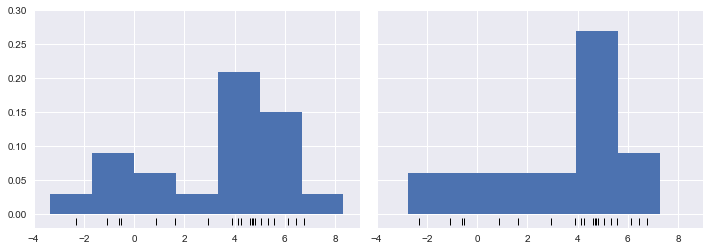

In [5]:
x = make_data(20)
bins = np.linspace(-5, 10, 10)

fig, ax = plt.subplots(1, 2, figsize=(12, 4), sharex=True, sharey=True,
                      subplot_kw=dict(xlim=(-4, 9), ylim=(-0.02, 0.3)))
fig.subplots_adjust(wspace=0.05)
for i, offset in enumerate([0.0, 0.6]):
    ax[i].hist(x, bins=bins + offset, normed=True)
    ax[i].plot(x, np.full_like(x, -0.01), '|k',
    markeredgewidth=1)

## 2. 核密度估计的实际应用

- 核心参数
    - 核密度估计的自由参数是核类型（kernel）参数，它可以指定每个点核密度分布的形状
    - 而核带宽（kernel bandwidth） 参数控制每个点的核的大小
- 在实际应用中， 有很多核可用于核密度估计， 特别是 ScikitLearn 的 KDE 实现支持六个核
- 在 sklearn.neighbors.KernelDensity 评估器中实现， 借助六个核中的任意一个核、 二三十个距离量度就可以处理具有多个维度的 KDE
- 由于KDE计算量非常大，因此Sklearn评估器底层使用了一种基于树的算法，可以利用atol（绝对容错）和rtol（相对容错）参数来平衡计算时间与准确性


(-0.02, 0.22)

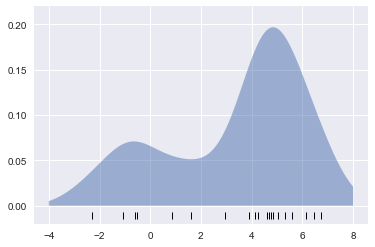

In [6]:
from sklearn.neighbors import KernelDensity

x_d = np.linspace(-4, 8, 1000)
# 初始化并拟合KDE模型
kde = KernelDensity(bandwidth=1.0, kernel='gaussian')
kde.fit(x[:, None])

# score_samples返回概率密度的绝对值
logprob = kde.score_samples(x_d[:, None])

plt.fill_between(x_d, np.exp(logprob), alpha=0.5)
plt.plot(x, np.full_like(x, -0.01), '|k', markeredgewidth=1)
plt.ylim(-0.02, 0.22)

- 我们可以用 ScikitLearn 的标准交叉检验工具来确定自由参数核带宽
- 在 KDE 中， 带宽的选择不仅对找到合适的密度估计非常重要， 也是在密度估计中控制偏差 - 方差平衡的关键
    - 带宽过窄将导致估计呈现高方差（即过拟合） ， 而且每个点的出现或缺失都会引起很大的不同； 
    - 带宽过宽将导致估计呈现高偏差（即欠拟合） ， 而且带宽较大的核还会破坏数据结构
- 机器学习中超参数的调优通常都是通过交叉检验完成的
    - 直接使用Scikit-Learn 的标准网格搜索工具
    - 这里用 GridSearchCV 来优化前面数据集的密度估计带宽
        - 因为我们要处理的数据集规模比较小， 所以使用留一法进行交叉检验， 该方法在每一次做交叉检验时， 都会最小化训练集的损失

In [7]:
# 这里用 GridSearchCV 来优化前面数据集的密度估计带宽使
# 用留一法进行交叉检验
from sklearn.grid_search import GridSearchCV
from sklearn.cross_validation import LeaveOneOut

bandwidths = 10 * np.linspace(-1, 1, 100)
grid = GridSearchCV(KernelDensity(kernel='gaussian'), {'bandwidth': bandwidths}, cv=LeaveOneOut(len(x)))
grid.fit(x[:, None])
# 可以找到似然估计值最大化时（在本例中默认是对数似然估值） 的带宽
print(grid.best_params_)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


{'bandwidth': -10.0}


## 3. 示例：球形空间的KDE

- KDE 可能最常用于描述数据点的分布。 
    - 例如， 在 Seaborn 可视化库中，KDE 是内置画图函数，可以自动对一维和二维空间的数据进行可视化
- 下面使用sklearn的一些地理数据：褐喉树懒和森林小稻鼠这两种南美洲哺乳类动物的地理分布观测值

In [19]:
from sklearn.datasets import fetch_species_distributions

data = fetch_species_distributions()

latlon = np.vstack([data.train['dd lat'], data.train['dd long']]).T
species = np.array([d.decode('ascii').startswith('mirco') for d in data.train['species']], dtype='int')

C:\ProgramData\Anaconda3\lib\site-packages\mpl_toolkits\basemap\__init__.py:1708: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  limb = ax.axesPatch
C:\ProgramData\Anaconda3\lib\site-packages\mpl_toolkits\basemap\__init__.py:1711: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  if limb is not ax.axesPatch:


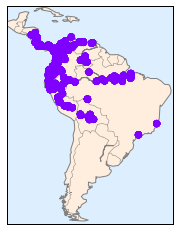

In [18]:
# 使用 Basemap 工具（详情请参见 4.15 节） 在南美洲地图中画出这两个物种的观测位置
from mpl_toolkits.basemap import Basemap
from sklearn.datasets.species_distributions import construct_grids

xgrid, ygrid = construct_grids(data)

# 用basemap画出海岸线
m = Basemap(projection='cyl', resolution='c',
           llcrnrlat=ygrid.min(), urcrnrlat=ygrid.max(),
           llcrnrlon=xgrid.min(), urcrnrlon=xgrid.max())
m.drawmapboundary(fill_color='#DDEEFF')
m.fillcontinents(color="#FFEEDD")
m.drawcoastlines(color='gray', zorder=2)
m.drawcountries(color='gray', zorder=2)

# 画出位置
m.scatter(latlon[:, 1], latlon[:, 0], zorder=3,
         c=species, cmap='rainbow', latlon=True)

- 用核密度估计以一种更容易解读的方式显示物种分布信息： 在地图中平滑地显示密度。 
- 由于地图坐标系统位于一个球面， 而不是一个平面上，因此可以使用 haversine 度量距离正确表示球面上的距离

C:\ProgramData\Anaconda3\lib\site-packages\mpl_toolkits\basemap\__init__.py:1708: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  limb = ax.axesPatch
C:\ProgramData\Anaconda3\lib\site-packages\mpl_toolkits\basemap\__init__.py:1711: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  if limb is not ax.axesPatch:
C:\ProgramData\Anaconda3\lib\site-packages\mpl_toolkits\basemap\__init__.py:1708: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  limb = ax.axesPatch
C:\ProgramData\Anaconda3\lib\site-packages\mpl_toolkits\basemap\__init__.py:1711: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  if limb is not ax.axesPatch:


ValueError: Found array with 0 sample(s) (shape=(0, 2)) while a minimum of 1 is required.

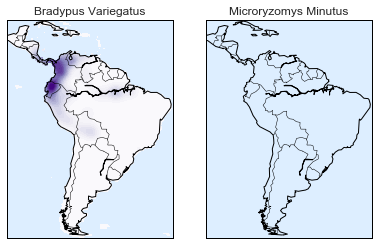

In [20]:
# 准备画轮廓图的数据点
X, Y = np.meshgrid(xgrid[::5], ygrid[::5][::-1])
land_reference = data.coverages[6][::5, ::5]
land_mask = (land_reference > -9999).ravel()
xy = np.vstack([Y.ravel(), X.ravel()]).T
xy = np.radians(xy[land_mask])

# 创建两幅并排的图
fig, ax = plt.subplots(1, 2)
fig.subplots_adjust(left=0.05, right=0.95, wspace=0.05)
species_names = ['Bradypus Variegatus', 'Microryzomys Minutus']
cmaps = ['Purples', 'Reds']

for i, axi in enumerate(ax):
    axi.set_title(species_names[i])

    # 用Basemap画出海岸线
    m = Basemap(projection='cyl', llcrnrlat=Y.min(),
                urcrnrlat=Y.max(), llcrnrlon=X.min(),
                urcrnrlon=X.max(), resolution='c', ax=axi)
    m.drawmapboundary(fill_color='#DDEEFF')
    m.drawcoastlines()
    m.drawcountries()
    
    # 构建一个球形的分布核密度估计
    kde = KernelDensity(bandwidth=0.03, metric='haversine')
    kde.fit(np.radians(latlon[species == i]))
    
    # 只计算大陆的值： -9999表示是海洋
    Z = np.full(land_mask.shape[0], -9999.0)
    Z[land_mask] = np.exp(kde.score_samples(xy))
    Z = Z.reshape(X.shape)
    
    # 画出密度的轮廓
    levels = np.linspace(0, Z.max(), 25)
    axi.contourf(X, Y, Z, levels=levels, cmap=cmaps[i])

## 4. 示例：不是很朴素的贝叶斯

- 用 KDE 做贝叶斯生成分类， 同时演示如何使用 ScikitLearn 自定义评估器
- 在朴素贝叶斯分类中， 生成模型是与坐标轴平行的高斯分布。 
    - 如果利用 KDE 这样的核密度估计算法， 我们就可以去掉“朴素”的成分，使用更成熟的生成模型描述每一个类。 
    - 虽然它还是贝叶斯分类， 但是它不再朴素
- 一般分类器的生成算法如下
    - 通过标签分割训练数据
    - 为每个集合拟合一个 KDE 来获得数据的生成模型， 这样就可以用任意 x 观察值和 y 标签计算出似然估计值 P ( x | y )
    - 根据训练集中每一类的样本数量， 计算每一类的先验概率 P ( y )
    - 对于一个未知的点 x， 每一类的后验概率是 P ( x | y ) ∝ P ( x | y )P ( y)， 而后验概率最大的类就是分配给该点的标签

In [32]:
from sklearn.base import BaseEstimator, ClassifierMixin

class KDEClassifier(BaseEstimator, ClassifierMixin):
    
    """基于KDE的贝叶斯生成分类
    参数
    ----------
    bandwidth : float
        每个类中的核带宽
    kernel : str
        核函数的名称， 传递给KernelDensity
    """

    def __init__(self, bandwidth=1.0, kernel='gaussian'):
        self.bandwidth = bandwidth
        self.kernel = kernel

    def fit(self, X, y):
        self.classes_ = np.sort(np.unique(y))
        training_sets = [X[y == yi] for yi in self.classes_]
        self.models_ = [KernelDensity(bandwidth=self.bandwidth,
                                      kernel=self.kernel).fit(Xi)
                        for Xi in training_sets]
        self.logpriors_ = [np.log(Xi.shape[0] / X.shape[0]) for Xi in training_sets]
        return self

    def predict_proba(self, X):
        logprobs = np.array([model.score_samples(X) for model in self.models_]).T
        result = np.exp(logprobs + self.logpriors_)
        return result / result.sum(1, keepdims=True)

    def predict(self, X):
        return self.classes_[np.argmax(self.predict_proba(X), 1)]

In [33]:
# 使用自定义评估器:手写数字的分类问题
from sklearn.datasets import load_digits
from sklearn.grid_search import GridSearchCV

digits = load_digits()

bandwidths = 10 ** np.linspace(0, 2, 100)
grid = GridSearchCV(KDEClassifier(), {'bandwidth': bandwidths})
grid.fit(digits.data, digits.target)

scores = [val.mean_validation_score for val in grid.grid_scores_]

{'bandwidth': 7.054802310718643}
accuracy = 0.9666110183639399


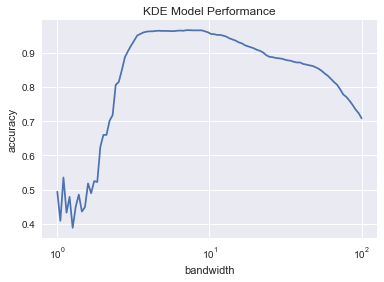

In [34]:
# 画出交叉检验值曲线， 用交叉检验值作为带宽函数
plt.semilogx(bandwidths, scores)
plt.xlabel('bandwidth')
plt.ylabel('accuracy')
plt.title('KDE Model Performance')
print(grid.best_params_)
print('accuracy =', grid.best_score_)

- 这个不是很朴素的贝叶斯分类器的交叉检验准确率达到了 96%， 而朴素贝叶斯分类器的准确率仅有 80%

In [35]:
from sklearn.naive_bayes import GaussianNB
from sklearn.cross_validation import cross_val_score
cross_val_score(GaussianNB(), digits.data, digits.target).mean()

0.8186003803550138